In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import statsmodels.api as sm
from io import StringIO

import preprocessor as pp
import emoji
from nltk.tokenize import TweetTokenizer
from sklearn.neighbors import KNeighborsClassifier



In [2]:
ds_train = pd.read_csv('../data/monkeypox_extra.csv')
ds_train = ds_train.drop('number', axis=1)
ds_train = ds_train.drop('created_at', axis=1)
ds_train = ds_train.drop('text', axis=1)
ds_train = ds_train.drop('source', axis=1)
ds_train = ds_train.drop('user description', axis=1)
ds_train = ds_train.drop('user created at', axis=1)
ds_train = ds_train.drop('user location', axis=1)
ds_train = ds_train.drop('ternary_class', axis=1)

ds_test = pd.read_csv('../data/monkeypox-followup_extra.csv')
ds_test = ds_test.drop('number', axis=1)
ds_test = ds_test.drop('created_at', axis=1)
ds_test = ds_test.drop('text', axis=1)
ds_test = ds_test.drop('source', axis=1)
ds_test = ds_test.drop('user description', axis=1)
ds_test = ds_test.drop('user created at', axis=1)
ds_test = ds_test.drop('user location', axis=1)
ds_test = ds_test.drop('ternary_class', axis=1)
ds_test = ds_test.drop('beto_flag', axis=1)



In [3]:
ds_train.describe()

,user is verified,user has url,user has alt account,account_age_months,retweet_count,reply_count,like_count,quote_count,followers count,following count,tweet count,listed_count,engagement,binary_class
count,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5.787000e+03,5787.000000,5.787000e+03,5787.000000,5787.000000,5787.000000
mean,0.069466,0.383791,0.007085,75.562122,2.742872,1.037671,13.870918,0.872991,3.678703e+04,1837.514429,6.042138e+04,219.029031,2.589382,0.184724
std,0.254267,0.486350,0.083880,58.974472,39.652237,9.291639,249.344399,22.910199,5.183490e+05,9586.056021,1.655682e+05,2070.980427,37.852424,0.388107
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,9.300000e+01,157.000000,2.918000e+03,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,68.000000,0.000000,0.000000,0.000000,0.000000,5.390000e+02,550.000000,1.381700e+04,3.000000,0.019789,0.000000
75%,0.000000,1.000000,0.000000,133.000000,0.000000,1.000000,2.000000,0.000000,2.733500e+03,1557.000000,5.090200e+04,26.000000,0.390180,0.000000
max,1.000000,1.000000,1.000000,186.000000,2281.000000,550.000000,14561.000000,1603.000000,2.212650e+07,436979.000000,2.735137e+06,72255.000000,2380.952381,1.000000


In [4]:
ds_train.columns

Index(['user is verified', 'user has url', 'user has alt account',
       'account_age_months', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'followers count', 'following count', 'tweet count',
       'listed_count', 'engagement', 'binary_class'],
      dtype='object')

In [5]:
ds_test.columns

Index(['user is verified', 'user has url', 'user has alt account',
       'account_age_months', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'followers count', 'following count', 'tweet count',
       'listed_count', 'engagement', 'binary_class'],
      dtype='object')

In [6]:
features = ds_train.columns[:-1]

ds_train_norm = ds_train.copy()
ds_test_norm = ds_test.copy()

for feature in features:
    feature_min = ds_train_norm[feature].min()
    feature_max = ds_train_norm[feature].max()
    ds_train_norm[feature] = (ds_train_norm[feature] - feature_min) / (feature_max - feature_min)    
    ds_test_norm[feature] = (ds_test_norm[feature] - feature_min) / (feature_max - feature_min)    


In [7]:
#Training Data Statistics
ds_train_norm.describe()

,user is verified,user has url,user has alt account,account_age_months,retweet_count,reply_count,like_count,quote_count,followers count,following count,tweet count,listed_count,engagement,binary_class
count,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000
mean,0.069466,0.383791,0.007085,0.406248,0.001202,0.001887,0.000953,0.000545,0.001663,0.004205,0.022090,0.003031,0.001088,0.184724
std,0.254267,0.486350,0.083880,0.317067,0.017384,0.016894,0.017124,0.014292,0.023427,0.021937,0.060534,0.028662,0.015898,0.388107
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.091398,0.000000,0.000000,0.000000,0.000000,0.000004,0.000359,0.001066,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.365591,0.000000,0.000000,0.000000,0.000000,0.000024,0.001259,0.005051,0.000042,0.000008,0.000000
75%,0.000000,1.000000,0.000000,0.715054,0.000000,0.001818,0.000137,0.000000,0.000124,0.003563,0.018610,0.000360,0.000164,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
ds_train_norm_cov = np.cov(ds_train_norm[features], rowvar=False)
print(f'Size of covariance matrix: {ds_train_norm_cov.shape}')

cov_subset = []
for row in range(5):
    cov_subset.append(ds_train_norm_cov[row][:5])
print('First 5 * 5 of covariance matrix:')
print(pd.DataFrame(cov_subset))

Size of covariance matrix: (13, 13)
First 5 * 5 of covariance matrix:
          0         1         2         3         4
0  0.064652  0.038147 -0.000492  0.025078  0.000280
1  0.038147  0.236536 -0.001337  0.041608  0.000377
2 -0.000492 -0.001337  0.007036 -0.000044 -0.000006
3  0.025078  0.041608 -0.000044  0.100532  0.000180
4  0.000280  0.000377 -0.000006  0.000180  0.000302


In [9]:
#Generate eigen values / vectors
eig_values, eig_vectors = np.linalg.eig(ds_train_norm_cov)

#Sort the arrays in terms of highest captured variance
idx = eig_values.argsort()[::-1]
eig_values = eig_values[idx]
eig_vectors = eig_vectors[:,idx]

print(f'Size of covariance matrix: {ds_train_norm_cov.shape}')
print(f'Length of eigen value list: {len(eig_values)}')
print(f'Size of eigen vector matrix: {eig_vectors.shape}')
print(f'Five largest eigen values:\n{eig_values[:5]}')
print(f'Five largest eigen values:\n{eig_vectors[:5]}')

Size of covariance matrix: (13, 13)
Length of eigen value list: 13
Size of eigen vector matrix: (13, 13)
Five largest eigen values:
[0.25830358 0.09360262 0.05023147 0.00702573 0.00343664]
Five largest eigen values:
[[ 2.20832595e-01  3.17281058e-01 -9.21223420e-01 -6.53596585e-03
  -1.93654730e-02  3.78876876e-02  2.93818891e-03  3.35261094e-03
   1.14297338e-03  1.42344989e-03 -5.65859130e-03 -5.56745157e-04
  -2.08652831e-03]
 [ 9.33203143e-01 -3.43209892e-01  1.05744897e-01 -5.36285663e-03
  -1.10473666e-02 -6.22240112e-04  1.47311938e-03 -1.14450123e-03
   1.38213424e-03 -4.96696186e-04 -8.18117717e-05  2.04706232e-04
   6.00484867e-05]
 [-5.44902342e-03  3.04183988e-03  6.86891416e-03 -9.99942034e-01
  -3.10507040e-03 -4.28962505e-04 -4.91543277e-04 -4.20257557e-03
   1.25032286e-03  2.86803054e-04  1.92633880e-04 -2.66225388e-04
  -5.66008989e-04]
 [ 2.82089144e-01  8.83100925e-01  3.72600969e-01  3.86079644e-03
  -4.08837627e-02  1.45537027e-04  1.57378404e-03 -5.92937434e-03
 

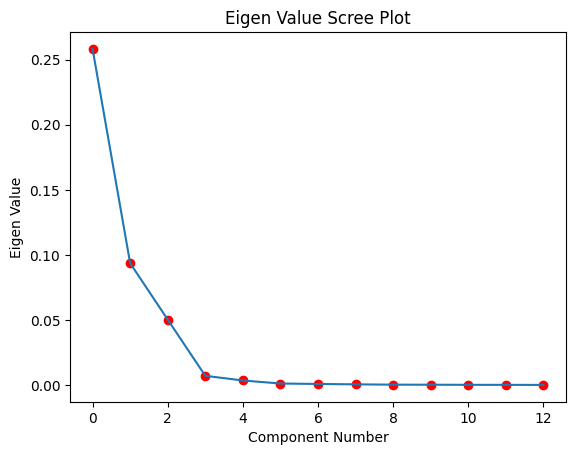

Explained Variance Table


,eigen_value,variance_perc,cum_variance_perc
0,0.258304,62.150591,62.150591
1,0.093603,22.521786,84.672377
2,0.050231,12.086227,96.758604
3,0.007026,1.690466,98.449070
4,0.003437,0.826891,99.275961
5,0.001108,0.266488,99.542449
6,0.000782,0.188231,99.730680
7,0.000472,0.113653,99.844333
8,0.000236,0.056865,99.901198
9,0.000187,0.045076,99.946274


In [10]:
#Created explained variance table to help with selection
df_variance = pd.DataFrame()
df_variance['eigen_value'] = eig_values
df_variance['variance_perc'] = (eig_values / sum(eig_values))*100
df_variance['cum_variance_perc'] = np.cumsum(df_variance['variance_perc'])

#Generate / show scree plot
plt.plot(eig_values,'ro')
plt.plot(eig_values)
plt.xlabel('Component Number') 
plt.ylabel('Eigen Value') 
plt.title("Eigen Value Scree Plot")
plt.show()

#Print explained variance table
print('Explained Variance Table')
df_variance

In [11]:
# Select the first three eigen vectors and transpose into row format (i.e. eigen vectors are the rows)
selected_eig_vectors = eig_vectors.T[:][:3]

# Apply transformation to the normalized training and testing data sets
ds_train_norm_pca_red = pd.DataFrame(selected_eig_vectors.dot(ds_train_norm[features].T).T)
ds_test_norm_pca_red = pd.DataFrame(selected_eig_vectors.dot(ds_test_norm[features].T).T)

ds_train_norm_pca_red

,0,1,2
0,0.197216,0.617309,0.260445
1,1.394900,0.726062,-0.499081
2,0.060778,0.190086,0.080163
3,1.397905,0.735526,-0.495043
4,1.404225,0.754882,-0.487141
...,...,...,...
5782,0.000005,0.000007,0.000003
5783,0.000005,0.000007,0.000003
5784,0.041012,0.128287,0.054097
5785,0.006109,0.019059,0.008045


In [12]:
# Create model using euclidean distance metric
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

# Train the model using the pca reduced training data
knn_model.fit(ds_train_norm_pca_red,ds_train_norm['binary_class'])

# Generate predictions using test data
predicted = knn_model.predict(ds_test_norm_pca_red)

# Print model accuracy
match = [x == y for x,y in zip(predicted,ds_test_norm['binary_class'])]
accuracy = sum(match) / len(match) * 100
print(f'Model accuracy: {accuracy:.2f}%')

# Generate data frame for csv export
results = pd.DataFrame(ds_test_norm_pca_red.copy())
results.columns=['PC1', 'PC2', 'PC3']
results['Ground Truth Class'] = ds_test_norm['binary_class']
results['Predicted Class'] = predicted

# Write CSV
results.to_csv('results.csv')

results

Model accuracy: 77.20%


,PC1,PC2,PC3,Ground Truth Class,Predicted Class
0,0.051925,0.161966,0.068209,0,0
1,-0.000008,0.000009,-0.000006,0,1
2,0.078873,0.246903,0.104171,0,0
3,0.463531,1.077000,-0.600719,0,0
4,1.174529,0.411975,0.424297,0,0
...,...,...,...,...,...
495,1.144034,0.316776,0.384194,0,0
496,0.230190,0.718667,0.302667,0,0
497,1.033465,-0.029615,0.237850,0,0
498,0.996948,-0.143730,0.189887,0,0
